In [1]:
import numpy as np
from matplotlib import pyplot as plt

from dftpy.ions import Ions
from dftpy.field import DirectField
from dftpy.grid import DirectGrid
from dftpy.functional import LocalPseudo, Functional, TotalFunctional, ExternalPotential
from dftpy.formats import io
from dftpy.math_utils import ecut2nr
from dftpy.optimization import Optimization


from ase.build import bulk
from ase.io.trajectory import Trajectory
from ase.lattice.spacegroup import Spacegroup
from ase.lattice.spacegroup import crystal

from sklearn.model_selection import train_test_split 
from sklearn.kernel_ridge import KernelRidge 
from dscribe.descriptors import CoulombMatrix, SineMatrix, EwaldSumMatrix, SOAP
from ase import Atoms
from ase.io import read

# import cWT

/opt/homebrew/lib/python3.11/site-packages/ase/lattice/spacegroup.py:5: UserWarning: Moved to ase.spacegroup
  warnings.warn('Moved to ase.spacegroup')


In [2]:
from ase import Atoms
d = 52

In [3]:
# He2.write('he2.vasp', format='vasp')
# He.write('he.vasp', format='vasp')

In [4]:
path_pp='/Users/valeria/Documents/PP/psl/'
file1='He.pz-rrkjus_psl.1.0.0.UPF'
PP_list = {'He': path_pp+file1}

In [5]:
rho0_KIN = np.load('rho_KIN.npy')
rho0_ENE = np.load('rho_ENE.npy')
# rho0_DEN = np.load('rho_DEN.npy')
# rho0_Btin_DEN_wt

In [6]:
rho_ks = io.read_density('he.xsf')
rho0_mean = rho_ks.mean()

In [7]:
vW_KE = Functional(type='KEDF',name='vW')
vW_KE(rho_ks).energy

2.498277227554556

In [8]:
2.4982909590984614

2.4982909590984614

In [9]:
def get_ions(path_file):
    inputfile = path_file
    ions = read(inputfile, format='vasp')
    return ions

In [10]:
PP_list = PP_list
XC = Functional(type='XC',name='LDA')
HARTREE = Functional(type='HARTREE')

In [11]:
material = get_ions('he.vasp')

In [12]:
material.get_cell_lengths_and_angles()

/opt/homebrew/lib/python3.11/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


array([10., 10., 10., 90., 90., 90.])

In [13]:
a = material.get_cell()[0]
r = np.sqrt(10**2 + 10**2)
R = np.sqrt(r**2 + 10**2)

In [14]:
WT_KE_ave = Functional(type='KEDF',name='WT')
WT_KE_den = Functional(type='KEDF',name='WT', rho0=1e-6)
WT_KE_kin = Functional(type='KEDF',name='WT', rho0=rho0_KIN)
WT_KE_ene = Functional(type='KEDF',name='WT', rho0=rho0_ENE)
lmgp = Functional(type='KEDF', name='LMGP')
rev_hc = Functional(type='KEDF', name='revHC')
hc = Functional(type='KEDF', name='HC')
vW_KE = Functional(type='KEDF',name='vW')
TF_KE = Functional(type='KEDF',name='TF')
lkt = Functional(type='KEDF',name='lkt')

# ions = Ions.from_ase(material)
# nr = ecut2nr(ecut=25, lattice=ions.cell)
# grid = DirectGrid(lattice=ions.cell, nr=nr)
# PSEUDO = LocalPseudo(grid = grid, ions=ions, PP_list=PP_list, rcut=20)

# rho_ini = DirectField(grid=grid)
# rho_ini[:] = ions.get_ncharges()/ions.cell.volume
# evaluator_kin = TotalFunctional(KE=WT_KE_kin, XC=XC, HARTREE=HARTREE, PSEUDO=PSEUDO)
# evaluator_den = TotalFunctional(KE=WT_KE_den, XC=XC, HARTREE=HARTREE, PSEUDO=PSEUDO)
# optimization_options = {'econv' : 1e-5*ions.nat}

# opt_kin = Optimization(EnergyEvaluator=evaluator_kin, optimization_options = optimization_options, optimization_method = 'TN')
# opt_den = Optimization(EnergyEvaluator=evaluator_den, optimization_options = optimization_options, optimization_method = 'TN')

# rho_kin = opt_kin.optimize_rho(guess_rho=rho_ini)
# rho_den = opt_den.optimize_rho(guess_rho=rho_ini)

In [15]:
vw_e = (vW_KE(rho_ks).potential)
wt_kin = (WT_KE_kin(rho_ks).potential)
wt_den = (WT_KE_den(rho_ks).potential)
wt_ene = (WT_KE_ene(rho_ks).potential)
lmgp_pot = lmgp(rho_ks).potential
revHC_pot = rev_hc(rho_ks).potential
hc_pot = hc(rho_ks).potential
lkt_pot = lkt(rho_ks).potential

In [26]:
lkt_pot.

dftpy.field.DirectField

In [16]:
tf_pot = TF_KE(rho_ks).potential

In [17]:
revhc_e =  rev_hc(rho_ks).energy - vW_KE(rho_ks).energy
wt_kin_e =  WT_KE_kin(rho_ks).energy - vW_KE(rho_ks).energy
wt_den_e =  WT_KE_den(rho_ks).energy - vW_KE(rho_ks).energy
wt_ene_e =  WT_KE_ene(rho_ks).energy - vW_KE(rho_ks).energy
lmgp_e   =  lmgp(rho_ks).energy - vW_KE(rho_ks).energy
lkt_e    =  lkt(rho_ks).energy - vW_KE(rho_ks).energy

In [18]:
def rmsd(vw_pot, nl_pot, rho):
    return (np.abs(nl_pot-vw_pot)*rho).integral()/(np.abs(vw_pot)*rho).integral()

In [19]:
revhc_rmsd = rmsd(vw_e, revHC_pot, rho_ks)
wt_kin_rmsd = rmsd(vw_e, wt_kin, rho_ks)
wt_den_rmsd = rmsd(vw_e, wt_den, rho_ks)   
wt_ene_rmsd = rmsd(vw_e, wt_ene, rho_ks)   

lmgp_rmsd  = rmsd(vw_e, lmgp_pot, rho_ks)
lkt_rmsd   = rmsd(vw_e, lkt_pot, rho_ks)

In [20]:
print('rev HC',revhc_e)
print('WT KIN',wt_kin_e)
print('WT DEN', wt_den_e) 
print('WT ENE', wt_ene_e) 
print('LMGP', lmgp_e )  
print('LKT', lkt_e )   

rev HC 1.3464351473434912
WT KIN 1.3700063505872606e-05
WT DEN -0.6495262813468012
WT ENE -0.6380003215029819
LMGP 0.21626366864416102
LKT 1.6357002614118499


In [19]:
print('rev HC', revhc_rmsd)
print('WT KIN',wt_kin_rmsd)
print('WT DEN', wt_den_rmsd) 
print('WT ENE', wt_ene_rmsd) 

print('LMGP', lmgp_rmsd )  
print('LKT', lkt_rmsd ) 

rev HC 0.8164195498035551
WT KIN 0.3485397424083169
WT DEN 0.37803581732222924
WT ENE 0.39639833731010765
LMGP 0.35085118156366263
LKT 1.053054591579053


In [20]:
v_diff =-(vw_e-wt_kin)

In [21]:
# v_diff =(tf_pot + wt_kin)

In [22]:
# Table  TF-NL  int(np.abs(V_TF + v_NL)*rho)
# KIN  
# DEN
# LMGP
# LKT

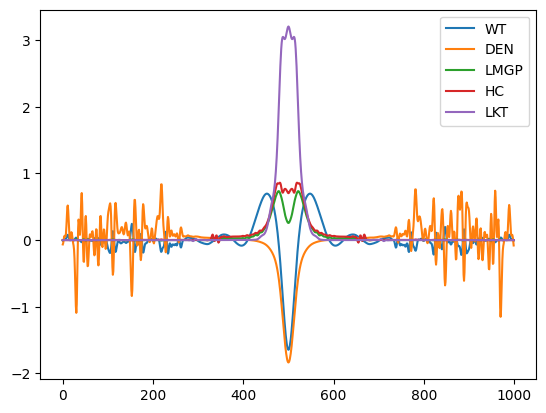

In [23]:
plt.plot(v_diff.get_cut(r0=[1,1,1], origin=[0,0,0], nr=1000, basis='crystal').ravel(), label='WT')
plt.plot(-(vw_e-wt_den).get_cut(r0=[1,1,1], origin=[0,0,0], nr=1000, basis='crystal').ravel(), label='DEN')
plt.plot(-(vw_e-lmgp_pot).get_cut(r0=[1,1,1], origin=[0,0,0], nr=1000, basis='crystal').ravel(), label='LMGP')
# plt.plot(-(vw_e-revHC_pot).get_cut(r0=[1,1,1], origin=[0,0,0], nr=1000, basis='crystal').ravel())
plt.plot(-(vw_e-hc_pot).get_cut(r0=[1,1,1], origin=[0,0,0], nr=1000, basis='crystal').ravel(), label='HC')
plt.plot(-(vw_e-lkt_pot).get_cut(r0=[1,1,1], origin=[0,0,0], nr=1000, basis='crystal').ravel(), label='LKT')
plt.legend()

In [23]:
sigma=0.0
den_vw = smooth(vw_e*rho_ks,sigma).get_cut(r0=[1,1,1], origin=[0,0,0], nr=1000, basis='crystal')
den_wt = smooth(wt_kin*rho_ks,sigma).get_cut(r0=[1,1,1], origin=[0,0,0], nr=1000, basis='crystal')
den_wt_den = smooth(wt_den*rho_ks,sigma).get_cut(r0=[1,1,1], origin=[0,0,0], nr=1000, basis='crystal')
den_wt_ene = smooth(wt_ene*rho_ks,sigma).get_cut(r0=[1,1,1], origin=[0,0,0], nr=1000, basis='crystal')

den_lkt = smooth(lkt_pot*rho_ks,sigma).get_cut(r0=[1,1,1], origin=[0,0,0], nr=1000, basis='crystal')
den_lmgp = smooth(lmgp_pot*rho_ks,sigma).get_cut(r0=[1,1,1], origin=[0,0,0], nr=1000, basis='crystal')
den_revhc = smooth(revHC_pot*rho_ks,sigma).get_cut(r0=[1,1,1], origin=[0,0,0], nr=1000, basis='crystal')

# hc_pot
# lkt_pot
# den_vw_x = vw_e.get_cut(r0=[1,0,0], origin=[0,0,0], nr=1000, basis='crystal')
# den_wt_x = wt_kin.get_cut(r0=[1,0,0], origin=[0,0,0], nr=1000, basis='crystal')

# den_vw_z = vw_e.get_cut(r0=[0,0,1], origin=[0,0,0], nr=1000, basis='crystal')
# den_wt_z = wt_kin.get_cut(r0=[0,0,1], origin=[0,0,0], nr=1000, basis='crystal')

In [124]:
den_vw[0]

DirectField([[3.77406276e-07]])

In [125]:
np.shape(vw_e.fft())

(96, 96, 49)

In [22]:
def smooth(field,sigma=0.3):
    ft = field.fft()
    gg = ft.grid.gg
    ft *= np.exp(-gg*sigma)
    return ft.ifft(force_real=True)

In [127]:
x = den_wt.ravel()

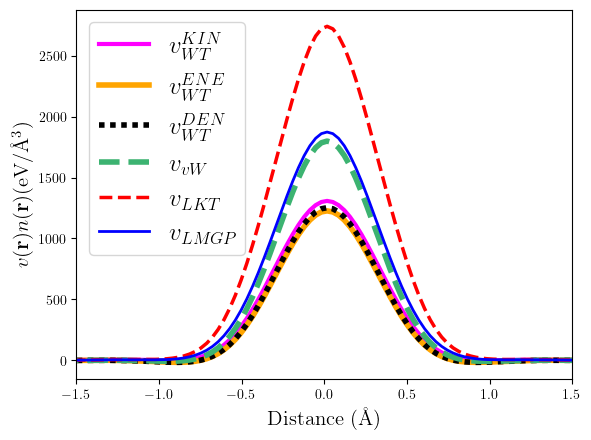

In [36]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif', stretch='condensed')
xx= np.linspace(-R,R,len(den_wt.ravel()))
ax = plt.figure().add_subplot(111)
ax.plot(xx, den_wt.ravel()*27.211407/0.529177**3, linewidth=3, color='magenta', label=r'$v_{WT}^{KIN}$')
ax.plot(xx, den_wt_ene.ravel()*27.211407/0.529177**3, linewidth=4.0, color='orange', label=r'$v_{WT}^{ENE}$')
ax.plot(xx, den_wt_den.ravel()*27.211407/0.529177**3, linewidth=4.0, color='black', linestyle=(0, (1,1)), label=r'$v_{WT}^{DEN}$')
ax.plot(xx, den_vw.ravel()*27.211407/0.529177**3, linewidth=4, color='mediumseagreen',linestyle='dashed',label=r'$v_{vW}$')
ax.plot(xx, den_lkt.ravel()*27.211407/0.529177**3, linewidth=2.5, color='red',linestyle='dashed', label=r'$v_{LKT}$')
ax.plot(xx, den_lmgp.ravel()*27.211407/0.529177**3, linewidth=2.0, color='blue', label=r'$v_{LMGP}$')
# plt.plot(den_revhc.ravel(), linewidth=1.5, color='C0', label=r'$v_{revHC}$')

# plt.ylabel('Potential')
plt.legend(fontsize=18)
ax.set_xlim(-1.5,1.5)
# plt.ylim(-0.5,16)
ax.set_xlabel(r'Distance (Å)', fontsize=15)
ax.set_ylabel(r'$v(\textbf{r})  n(\textbf{r}) $(eV/Å$^3$)', fontsize=15)
plt.savefig('pot_WT_vW_1.png', bbox_inches='tight', dpi=200)
# ax = plt.axes() 
# ax.set_xticks([-1,0,1])
# axs[0,0].tick_params(axis='both', labelsize=18)
# plt.plot(den_vw_x.ravel(), linewidth=1, color='blue')
# plt.plot(den_wt_x.ravel(), linewidth=1, color='red')

# plt.plot(den_vw_z.ravel(), linewidth=1, color='blue')
# plt.plot(den_wt_z.ravel(), linewidth=1, color='red')

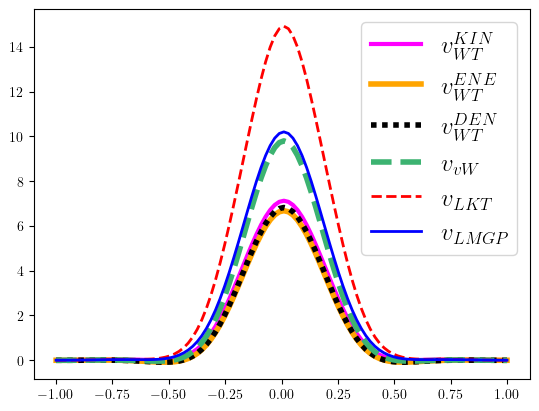

In [128]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif', stretch='condensed')
xx= np.linspace(-1,1,len(den_wt[450:550].ravel()))
ax = plt.figure().add_subplot(111)
ax.plot(xx, den_wt[450:550].ravel(), linewidth=3, color='magenta', label=r'$v_{WT}^{KIN}$')
ax.plot(xx, den_wt_ene[450:550].ravel(), linewidth=4.0, color='orange', label=r'$v_{WT}^{ENE}$')
ax.plot(xx, den_wt_den[450:550].ravel(), linewidth=4.0, color='black', linestyle=(0, (1,1)), label=r'$v_{WT}^{DEN}$')
ax.plot(xx, den_vw[450:550].ravel(), linewidth=4, color='mediumseagreen',linestyle='dashed',label=r'$v_{vW}$')
ax.plot(xx, den_lkt[450:550].ravel(), linewidth=2.0, color='red',linestyle='dashed', label=r'$v_{LKT}$')
ax.plot(xx, den_lmgp[450:550].ravel(), linewidth=2.0, color='blue', label=r'$v_{LMGP}$')
# plt.plot(den_revhc.ravel(), linewidth=1.5, color='C0', label=r'$v_{revHC}$')

# plt.ylabel('Potential')
plt.legend(fontsize=18)
# plt.xlim(450,550)
# plt.ylim(-0.5,16)
plt.savefig('pot_WT_vW.png', bbox_inches='tight', dpi=200)
# ax = plt.axes() 
# ax.set_xticks([-1,0,1])
# axs[0,0].tick_params(axis='both', labelsize=18)
# plt.plot(den_vw_x.ravel(), linewidth=1, color='blue')
# plt.plot(den_wt_x.ravel(), linewidth=1, color='red')

# plt.plot(den_vw_z.ravel(), linewidth=1, color='blue')
# plt.plot(den_wt_z.ravel(), linewidth=1, color='red')

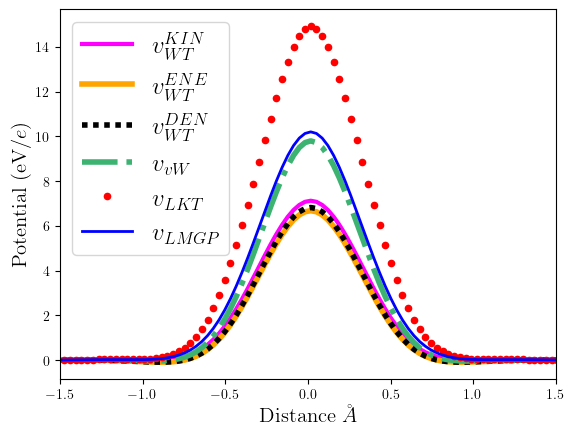

In [171]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif', stretch='condensed')
xx= np.linspace(-R,R,len(den_wt.ravel()))
ax = plt.figure().add_subplot(111)
ax.plot(xx, den_wt.ravel(), linewidth=3, color='magenta', label=r'$v_{WT}^{KIN}$')
ax.plot(xx, den_wt_ene.ravel(), linewidth=4.0, color='orange', label=r'$v_{WT}^{ENE}$')
ax.plot(xx, den_wt_den.ravel(), linewidth=4.0, color='black', linestyle=(0, (1, 1)), label=r'$v_{WT}^{DEN}$')
ax.plot(xx, den_vw.ravel(), linewidth=4, color='mediumseagreen',linestyle='dashdot',label=r'$v_{vW}$')
ax.plot(xx, den_lkt.ravel(), '.', markersize = 9, linewidth=2.5, color='red', label=r'$v_{LKT}$')
ax.plot(xx, den_lmgp.ravel(), linewidth=2.0, color='blue', label=r'$v_{LMGP}$')
# plt.plot(den_revhc.ravel(), linewidth=1.5, color='C0', label=r'$v_{revHC}$')

# plt.ylabel('Potential')
plt.legend(fontsize=18)
ax.set_xlim(-1.5,1.5)
# plt.ylim(-0.5,16)
ax.set_xlabel(r'Distance $\AA$', fontsize=15)
ax.set_ylabel(r'Potential (eV/$e$)', fontsize=15)
plt.savefig('pot_WT_vW_3.png', bbox_inches='tight', dpi=200)
# ax = plt.axes() 
# ax.set_xticks([-1,0,1])
# axs[0,0].tick_params(axis='both', labelsize=18)
# plt.plot(den_vw_x.ravel(), linewidth=1, color='blue')
# plt.plot(den_wt_x.ravel(), linewidth=1, color='red')

# plt.plot(den_vw_z.ravel(), linewidth=1, color='blue')
# plt.plot(den_wt_z.ravel(), linewidth=1, color='red')

$\mathdefault{−0.25}$
$\mathdefault{0.00}$
$\mathdefault{0.25}$
$\mathdefault{0.50}$
$\mathdefault{0.75}$
$\mathdefault{1.00}$
$\mathdefault{1.25}$
$\mathdefault{1.50}$
$\mathdefault{1.75}$
$\mathdefault{2.00}$
$\mathdefault{2.25}$


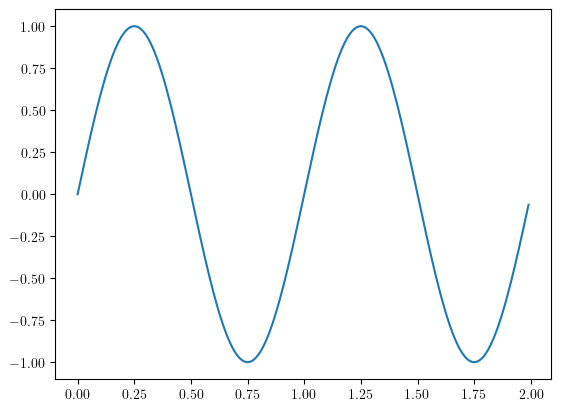

In [71]:
import matplotlib.pyplot as plt
import numpy as np

axes = plt.figure().add_subplot(111)
t = np.arange(0.0, 2.0, 0.01)
s = np.sin(2*np.pi*t)
axes.plot(t, s)
for ticklabel in axes.get_xticklabels():
    print(ticklabel.get_text())

In [ ]:
pwd

In [ ]:
plt.plot(rho_ks.ravel())

In [ ]:
plt.plot(wt_kin.ravel(), label = "WT KIN")
plt.plot(vw_e.ravel(), alpha=0.5, label="vW")
plt.legend()

In [ ]:
plt.plot(rho_ks.get_cut(r0=[1,1,1], origin=[0,0,0], nr=1000, basis='crystal').ravel())
# plt.plot(rho_ks.ravel())

In [ ]:
plt.plot

In [ ]:
vw_e = (vW_KE(rho_ks).potential)

In [ ]:
wt_kin = (WT_KE_kin(rho_ks).potential)

In [ ]:
plt.plot((vw_e-wt_kin).ravel())
plt.ylim(-10,10)

In [ ]:
# plt.plot(wt_ene.ravel())
# plt.plot(wt_den.ravel())
plt.plot(wt_kin.ravel())
plt.plot(vw_e.ravel(), alpha=0.5)
# plt.ylim((-100,100))

In [ ]:
def TF_NL(material, r, rho0_ene, rho0_kin):
    WT_KE_ave = Functional(type='KEDF',name='WT')
    WT_KE_ene = Functional(type='KEDF',name='WT', rho0=rho0_ene)
#         WT_KE_den = Functional(type='KEDF',name='WT', rho0=np.asarray(rho0_den[0]).min())
    WT_KE_kin = Functional(type='KEDF',name='WT', rho0=rho0_kin)

    vW_KE = Functional(type='KEDF',name='vW')
    TF_KE = Functional(type='KEDF',name='TF')

    ions = Ions.from_ase(material)
    nr = ecut2nr(ecut=25, lattice=ions.cell)
    grid = DirectGrid(lattice=ions.cell, nr=nr)
    PSEUDO = LocalPseudo(grid = grid, ions=ions, PP_list=PP_list, rcut=20)

    rho_ini = DirectField(grid=grid)
    rho_ini[:] = ions.get_ncharges()/ions.cell.volume
#     WT_KE_scale = Functional(type='KEDF',name='WT', z=rho_ini.mean()/float(rho0_mean))

    evaluator_ave = TotalFunctional(KE=WT_KE_ave, XC=XC, HARTREE=HARTREE, PSEUDO=PSEUDO)
    evaluator_ene = TotalFunctional(KE=WT_KE_ene, XC=XC, HARTREE=HARTREE, PSEUDO=PSEUDO)
#         evaluator_den = TotalFunctional(KE=WT_KE_den, XC=XC, HARTREE=HARTREE, PSEUDO=PSEUDO)
    evaluator_kin = TotalFunctional(KE=WT_KE_kin, XC=XC, HARTREE=HARTREE, PSEUDO=PSEUDO)
    evaluator_vw = TotalFunctional(KE=vW_KE, XC=XC, HARTREE=HARTREE, PSEUDO=PSEUDO)
#     evaluator_sca = TotalFunctional(KE=WT_KE_scale, XC=XC, HARTREE=HARTREE, PSEUDO=PSEUDO)

    optimization_options = {'econv' : 1e-5*ions.nat}

    opt_ave = Optimization(EnergyEvaluator=evaluator_ave, optimization_options = optimization_options, optimization_method = 'TN')
    opt_ene = Optimization(EnergyEvaluator=evaluator_ene, optimization_options = optimization_options, optimization_method = 'TN')
#         opt_den = Optimization(EnergyEvaluator=evaluator_den, optimization_options = optimization_options, optimization_method = 'TN')
    opt_kin = Optimization(EnergyEvaluator=evaluator_kin, optimization_options = optimization_options, optimization_method = 'TN')
    opt_vw = Optimization(EnergyEvaluator=evaluator_vw, optimization_options = optimization_options, optimization_method = 'TN')
#     opt_sca = Optimization(EnergyEvaluator=evaluator_sca, optimization_options = optimization_options, optimization_method = 'TN')

    rho_ave = opt_ave.optimize_rho(guess_rho=rho_ini)
    rho_ene = opt_ene.optimize_rho(guess_rho=rho_ini)
#         rho_den = opt_den.optimize_rho(guess_rho=rho_ini)
    rho_kin = opt_kin.optimize_rho(guess_rho=rho_ini)
    rho_vw = opt_vw.optimize_rho(guess_rho=rho_ini)
#     rho_sca = opt_sca.optimize_rho(guess_rho=rho_ini)

    wt_e_ave = (WT_KE_ave(rho_ave).potential)
#         wt_e_den.append(WT_KE_den(rho_ene).energy)
    wt_e_ene = (WT_KE_ene(rho_ene).potential)
    wt_e_kin = (WT_KE_kin(rho_kin).potential)
    vw_e = (vW_KE(rho_vw).potential)
    tf_e = (TF_KE(rho_vw).potential)
#     wt_s = (WT_KE_scale(rho_sca).potential)
    rho0_mean = (rho_ini.mean())
    print('vW ENERGY!!!', vW_KE(rho_ks).energy)
    return np.asarray(wt_e_ave), np.asarray(vw_e), np.asarray(tf_e), np.asarray(wt_e_ene), np.asarray(wt_e_kin)

In [ ]:
tf_wt = TF_NL(ions, 1, rho0_ENE, rho0_KIN)
wt_ave =tf_wt[0]
vw_e =tf_wt[1]
tf_e =tf_wt[2]
wt_ene =tf_wt[3]
wt_kin =tf_wt[4]